# IMaGES on ROI time series

In [1]:
import os
import pickle
from os.path import join as pjoin
import glob
import pandas as pd
import numpy as np
import pydot
from IPython.display import SVG
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import pyplot, patches
from pycausal import pycausal as pc
from pycausal import search as s
import networkx as nx
from networkx.drawing import nx_pydot
import itertools
import copy
import mne
from mayavi import mlab
import bct

In [2]:
# show relevant package versions
!pip freeze | grep -e pycausal -e jupyter

jupyter==1.0.0
jupyter-client==5.0.1
jupyter-console==5.1.0
jupyter-core==4.3.0
pycausal==0.1.4


In [3]:
%matplotlib inline

In [4]:
sb.set_context('notebook')

In [91]:
def getdfs(csvdir):
    """
    give us list of data frames for csv files in directory.
    """
    dfs = []
    for csvfile in glob.glob(csvdir + os.sep + "*.csv"):
        df = pd.read_csv(csvfile)
        dfs.append(df)
        
    def _assert_dfs(dfs):
        """
        Check if all csv files are found and read into list of data frames.
        """
        if len(dfs) != 33*11:
            print('only %i of 363 csv files found' % len(dfs))
    _assert_dfs(dfs)
    
    return dfs

In [6]:
def run_images_lofs(dfs,
                    withlofs=True,
                    lofsrule='R3',
                    lofsscore='andersonDarling',
                    maxdegree=30,
                    penalty=4):
    """
    run IMaGES and optionally LOFS post-processing on a given list of dataframes.
    Return the graph instance of either images or lofs output.
    """
    pc.start_vm() 
    
    images = s.imagesSemBic(dfs, verbose=True, maxDegree=maxdegree, penaltyDiscount=penalty)
    if withlofs:
        tetradGraph = images.getTetradGraph()    
        lofs = s.lofs(tetradGraph, dfs, dataType=0, rule=lofsrule, score=lofsscore)
    
        pc.stop_vm()
        return lofs
    else:
        pc.stop_vm()
        return images

In [7]:
def plot_svg(images_instance):
    """
    Take graph instance from IMaGES or LOFS and plot the SVG.
    
    """
    dot = images_instance.getDot()
    svg_str = dot.create_svg(prog='dot')
    svg = SVG(svg_str)
    return svg

In [8]:
def save_dot2svg(dot, outname):
    """
    save svg from dot file & return svg
    """
    svg = dot.create_svg()
    with open(outname, 'w') as f:
        f.write(svg)
    return svg

## Preprocessed BOLD data

In [92]:
# directory with csv files for roi time series (seperate csv file for each run)
csvdir_allruns = pjoin('/host', 'famfaces', 'extract_meants', 'csv', 'allruns')
dfs = getdfs(csvdir_allruns)

In [10]:
lofs_raw = run_images_lofs(dfs)

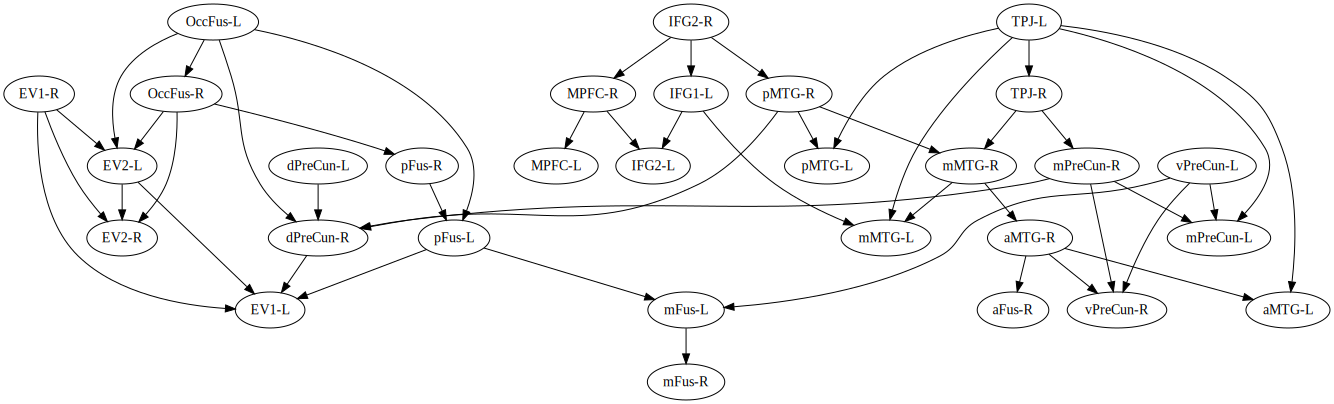

In [11]:
plot_svg(lofs_raw)

In [12]:
## get nodes
nodes = [str(node) for node in lofs_raw.getNodes()]

# pycausal instance to networkx graph

In [13]:
def pc2nx(images_instance):
    """
    Take the result from IMaGES or IMaGES+LOFS and return
    a networkx directed multigraph.
    """
    G = nx.drawing.nx_pydot.from_pydot(images_instance.graph)
    return G

In [14]:
def images2AM(images_instance, directed=True):
    """
    Take IMaGES instance and return directed adjacency matrix.
    TODO: sort by node list alphabetically. Or done automatically?
    """
    G = pc2nx(images_instance)
    if not directed:
        G = G.to_undirected()
    am = nx.adjacency_matrix(G, nodelist=nodes).toarray()
    return am

## Residuals

From a nuisance model with motion parameters, outliers, and button press as regressors.

In [95]:
# nuisance data with button press
dfs_nb = getdfs(pjoin('/host', 'famfaces', 'extract_meants_nuisance_button', '*', 'run*'))

In [96]:
"""
# check which csv files exactly are missing

from os import listdir
import glob
files = glob.glob(pjoin('/host', 'famfaces', 'extract_meants_nuisance_button', 'csv', 'run*', '*'))
#print(files)

for sub_nr in range(1,34):
    for run_nr in range(1,12):
        expected = pjoin('/host', 'famfaces', 'extract_meants_nuisance_button', 'csv', 'run%02d' % run_nr,
                         'sub%03d_run%02d.csv' % (sub_nr, run_nr))
        if not expected in files:
            print('missing %s' % expected)
"""

missing /host/famfaces/extract_meants_nuisance_button/csv/run01/sub012_run01.csv
missing /host/famfaces/extract_meants_nuisance_button/csv/run02/sub012_run02.csv
missing /host/famfaces/extract_meants_nuisance_button/csv/run03/sub012_run03.csv
missing /host/famfaces/extract_meants_nuisance_button/csv/run04/sub012_run04.csv
missing /host/famfaces/extract_meants_nuisance_button/csv/run05/sub012_run05.csv
missing /host/famfaces/extract_meants_nuisance_button/csv/run06/sub012_run06.csv
missing /host/famfaces/extract_meants_nuisance_button/csv/run07/sub012_run07.csv
missing /host/famfaces/extract_meants_nuisance_button/csv/run08/sub012_run08.csv
missing /host/famfaces/extract_meants_nuisance_button/csv/run09/sub012_run09.csv
missing /host/famfaces/extract_meants_nuisance_button/csv/run10/sub012_run10.csv
missing /host/famfaces/extract_meants_nuisance_button/csv/run11/sub012_run11.csv


In [97]:
lofs_nb = run_images_lofs(dfs_nb)

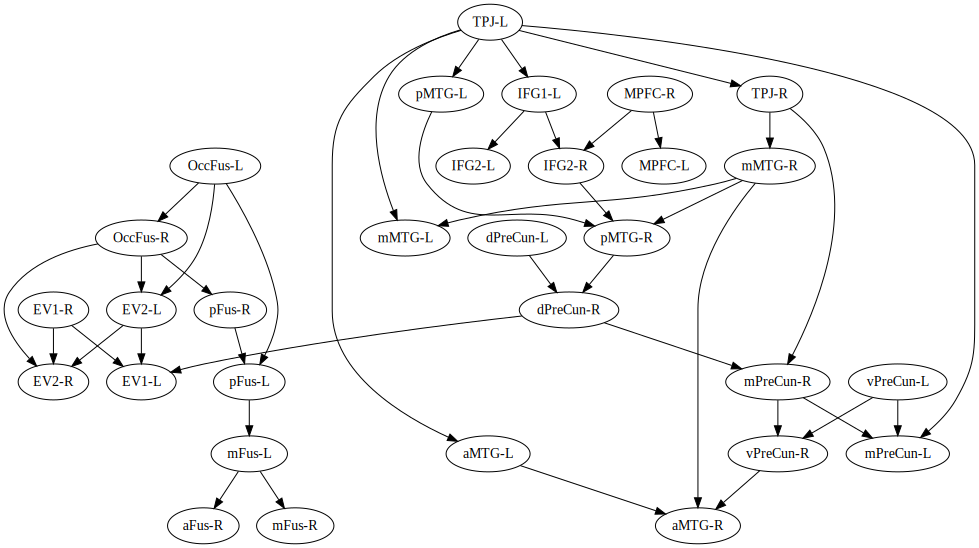

In [98]:
plot_svg(lofs_nb)

## Residual data without button press as regressor

In [18]:
dfs_n = getdfs(pjoin('/host', 'famfaces', 'extract_meants_nuisance', 'csv', 'run*'))

In [19]:
lofs_n = run_images_lofs(dfs_n)

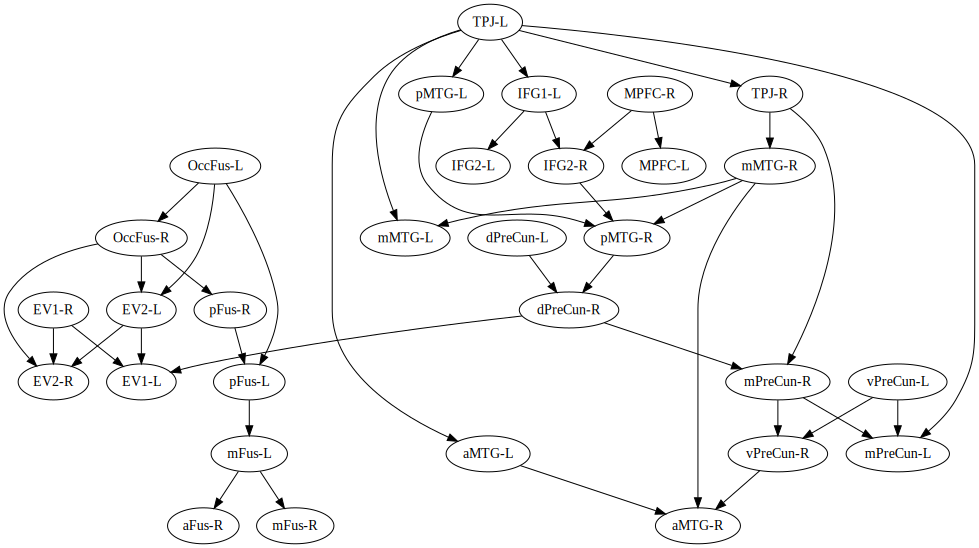

In [20]:
plot_svg(lofs_n)

# residuals with noise components (ec_preproc)

In [64]:
dfs_ecp = getdfs(pjoin('/host', 'famfaces', 'extract_meants_ecpreproc_allruns'))

In [68]:
lofs_ecp = run_images_lofs(dfs_ecp)

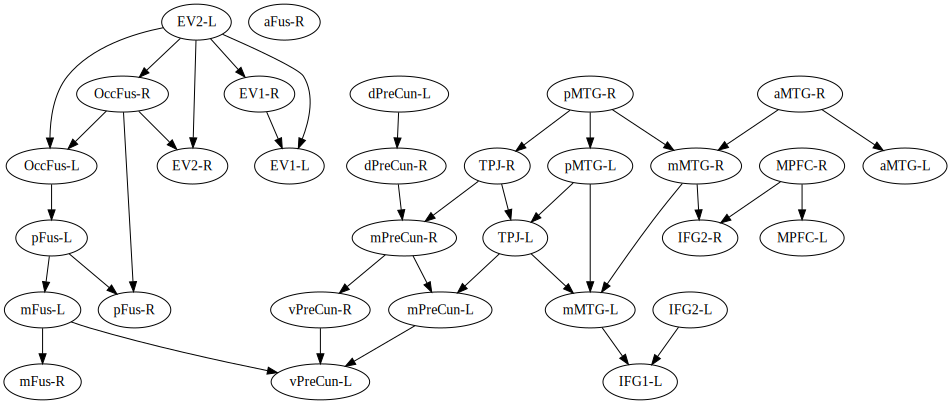

In [69]:
plot_svg(lofs_ecp)

# Get undirected adjacency matrices

In [21]:
# AM of undirected graphs from preprocessed and residual data
am_und_raw = images2AM(lofs_raw, directed=False)
am_und_nb = images2AM(lofs_nb, directed=False)
am_und_n = images2AM(lofs_n, directed=False)

# plot undirected connectivity with circular layout

In [22]:
def plot_connectivity_circle(undirected_AM, nodes, fsize=(10,10), title=None):
    """
    plot connectivity structure in circular layout using mne package.
    makes sense only for undirected graphs.
    """
    fig = plt.figure(figsize=fsize, facecolor='white')

    connect_kwargs = dict(
        facecolor = 'white',
        textcolor = 'black',
        fontsize_names=18,
        fontsize_colorbar=14,
        colormap = 'Greys',
        node_edgecolor='white',
        colorbar=False,
        interactive=False,
        node_linewidth=4,
        linewidth=2,
        vmin=0,
        vmax=1,
        show=False)

    f, ax = mne.viz.plot_connectivity_circle(undirected_AM, # change type from matrix to ndarray
                                     nodes,
                                     fig=fig, **connect_kwargs)
    if title:
        plt.title(title, fontweight='bold', fontsize=18)
    return fig

In [23]:
# alphabetically sorted list of nodes
sorted_nodes = sorted([str(node) for node in lofs_n.getNodes()])

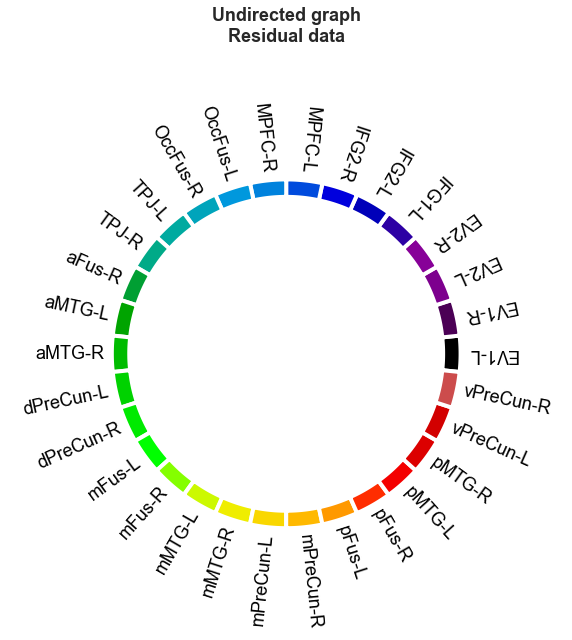

In [24]:
circ_und_n = plot_connectivity_circle(am_und_n, sorted_nodes, title='Undirected graph\nResidual data')

# Graph Matching methods

**Simple matching**

return the fraction of identical elements between two arrays

In [25]:
def simple_match(m1, m2):
    """
    return the relative number of identical elements between two arrays.
    """
    assert np.shape(m1) == np.shape(m2)
    return float(np.sum(m1 == m2)) / float(m1.size)

In [26]:
# simple matching graphs from preprocessed and residual data
match_residuals_preprocessed = simple_match(am_und_raw, am_und_nb)
print(match_residuals_preprocessed)

0.98


**Jaccard Index**

Use Scikit learn. Basically, the Jaccard index is the intersection divided by the union of two sets.

In [27]:
from sklearn.metrics import jaccard_similarity_score as jaccard

In [28]:
# jaccard index comparing graphs from preprocessed and residual data
jaccard(am_und_raw, am_und_nb)

0.82000000000000006

## Similarity across runs of undirected graphs (preprocessed data)

In [29]:
basedir = '/host/famfaces/extract_meants/csv'
rundirs_raw = [pjoin(basedir, 'run%03d' % i) for i in xrange(1,12)]

In [30]:
def csv2am(rundir, directed=True):
    """
    perform graph search and return undirected adjacency matrix of the represented graph
    """

    dfs = getdfs(rundir)
    images_instance = run_images_lofs(dfs)
    if directed:
        am = images2AM(images_instance, directed=True)
    else:
        am = images2AM(images_instance, directed=False)
    return am

In [31]:
def get_all_ams(rundirs, directed=True):
    """
    get adjacency matrices of all runs
    """
    if directed:
        am_list = [csv2am(rundir, directed=True) for rundir in rundirs]
    else:
        am_list = [csv2am(rundir, directed=False) for rundir in rundirs]
    return am_list

In [32]:
## this command takes a while to execute
am_list = get_all_ams(rundirs_raw, directed=False)

In [33]:
# save am_list as pickle
# with open('am_list.pickle', 'wb') as handle:
#    pickle.dump(am_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('am_list.pickle', 'rb') as handle:
#     am_list = pickle.load(handle)

In [34]:
def compare_runs(am_list, method='simple', symmetric=False):
    """
    pairwise comparison of matrices in a list of matrices.
    Choose between different measures of similarity.
    Choose if the input matrices are symmetric, due to undirected graphs.
    """
    
    if symmetric:
        am_list = [np.triu(am) for am in am_list]
    
    if method=='simple':
        match_list = np.array([
            [simple_match(am1, am2) for am1 in am_list]
            for am2 in am_list])
        
    if method=='jaccard':
        match_list = np.array([
            [jaccard(am1, am2) for am1 in am_list]
            for am2 in am_list])
        
    return match_list

In [35]:
def plot_match_matrix(match_matrix, ttl=None, axis=None):
    
    if axis:
        matrixplot = sb.heatmap(match_matrix, square=True, cmap='viridis', ax=axis)
    else:
        matrixplot = sb.heatmap(match_matrix, square=True, cmap='viridis')
    plt.xticks(np.arange(0.5, 11.5, 1), range(1,12))
    plt.yticks(np.arange(0.5, 11.5, 1), range(11,0,-1))
    
    if ttl:
        plt.title(ttl, fontweight='bold')

    print('minimum: ' + str(np.min(match_matrix)))
    print('maximum: ' + str(np.max(match_matrix)))
    print('mean: ' + str(np.mean(match_matrix)))

    return matrixplot

In [36]:
# simple matching of undirected adjacency matrices for preprocessed data
match_matrix_raw = compare_runs(am_list, symmetric=True)

In [37]:
def plot_clustered(matrix, colormap='viridis', meth='average',
                   dendrogram=False, ttl=None, colorbar=True):
    """
    Plot clustered correlation matrix using seaborn's clustermap.
    """

    clustermap = sb.clustermap(matrix, cmap='viridis', method=meth, figsize=(7,7),
                               xticklabels=range(1,12),
                               yticklabels=range(1,12))
    if not dendrogram:
        clustermap.ax_row_dendrogram.set_visible(False)
        clustermap.ax_col_dendrogram.set_visible(False)
    if not colorbar:
        clustermap.cax.set_visible(False)
    if ttl:
        clustermap.ax_heatmap.set_title(ttl, fontweight='bold', loc='center', fontsize=14)

    return clustermap

In [38]:
# jaccard index of undirected adjacency matrices for preprocessed data
jaccard_matrix_raw = compare_runs(am_list, method='jaccard', symmetric=True)

## Similarity across runs of DIRECTED graphs (preprocessed data)

In [39]:
# get mixed adjacency matrices for preprocessed data
mixed_ams = [csv2am(rundir, directed=True) for rundir in rundirs_raw]
np.shape(mixed_ams)

(11, 30, 30)

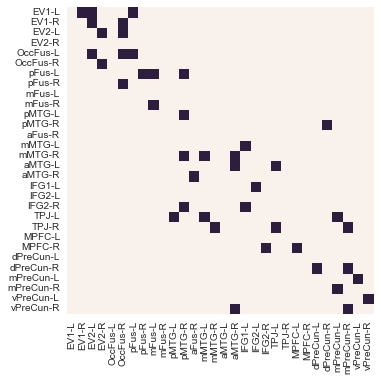

In [40]:
# inspect one random am
sb.heatmap(mixed_ams[1],
           cbar=False, square=True,
           xticklabels=nodes, yticklabels=nodes)

In [41]:
# with open('mixed_ams.pickle', 'wb') as handle:
#     pickle.dump(mixed_ams, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [42]:
# simple matching of directed adjacency matrices from preprocessed data
simple_matches_directed = compare_runs(mixed_ams)

In [43]:
# jaccard index of directed adjacency matrices from preprocessed data
jaccard_directed = compare_runs(mixed_ams, method='jaccard')

## Similarity across runs of undirected graphs (residual data, with button press)

This is not to be used for the overview plot but rather just for completeness. We decided that regressing out button press might remove actual signal. Therefore, we want to focus on nuisance model with only motion and artifact regressors.

In [44]:
basedir_nb = '/host/famfaces/extract_meants_nuisance_button/csv'
rundirs_nb = [pjoin(basedir_nb, 'run%02d' % i) for i in xrange(1,12)]

In [45]:
# again, this takes a while. use pickle
am_list_nb = get_all_ams(rundirs_nb, directed=False)

In [46]:
# save am_list_nb as pickle
#with open('am_list_nb.pickle', 'wb') as handle:
#    pickle.dump(am_list_nb, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
# Graph similarity (simple matching) across runs for residual data
match_matrix_nb = compare_runs(am_list_nb, symmetric=True)

In [48]:
# graph similarity (jaccard index) for residual data
jaccard_matrix_nb = compare_runs(am_list_nb, method='jaccard', symmetric=True)

## Similarity across runs of undirected graphs (residual data, without button press)

In [49]:
basedir_n = '/host/famfaces/extract_meants_nuisance/csv'
rundirs_n = [pjoin(basedir_n, 'run%02d' % i) for i in xrange(1,12)]

In [50]:
# list of undirected adjacency matrices
am_list_n = get_all_ams(rundirs_n, directed=False)

In [51]:
# graph comparison
match_matrix_n = compare_runs(am_list_n, symmetric=True)
jaccard_matrix_n = compare_runs(am_list_n, method='jaccard', symmetric=True)

## Similarity across runs of DIRECTED graphs (residual data, without button press)

In [52]:
# list of directed adjacency matrices
am_list_directed_n = get_all_ams(rundirs_n, directed=True)

In [53]:
# graph comparison
match_matrix_n_dir = compare_runs(am_list_directed_n, symmetric=True)
jaccard_matrix_n_dir = compare_runs(am_list_directed_n, method='jaccard', symmetric=True)

# Overview plot

In [54]:
def overview_plot(fonts=16, figs=(20,8), equal_limits=False):
    """
    Make an overview plot containing heatmaps in two rows, and four columns.
    Each heatmap represents graph similarity across runs.
    We plot seperate heatmaps for each similarity measure (jaccard vs. simple matching),
    data used (preprocessed vs. residual), and directionality of edges (undirected vs. directed).
    """
    # TODO: make this function more flexible
    
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=figs)
    
    # arguments for seaborn heatmap plot
    kwargs = {'xticklabels': range(1,12),
              'yticklabels': range(1,12),
              'cbar': True,
              'square': True,
              'cmap': 'viridis'}

    # set equal vmin and vmax to all color bars if desired 
    if equal_limits:
        kwargs['vmin'] = np.min([match_matrix_raw, jaccard_matrix_raw, simple_matches_directed,
                                 jaccard_directed, match_matrix_n, jaccard_matrix_n])
        kwargs['vmax'] = np.max([match_matrix_raw, jaccard_matrix_raw, simple_matches_directed,
                                 jaccard_directed, match_matrix_n, jaccard_matrix_n])
        
    # preprocessed data (left half of panel)

    positions_prep = [(0,0), (0,1), (1,0), (1,1)]
    matrices_prep = [match_matrix_raw, jaccard_matrix_raw, simple_matches_directed, jaccard_directed]
    titles_prep = ['simple matching\npreprocessed data', 'jaccard\npreprocessed data'] *2
        
    for mat, pos, ttl in zip(matrices_prep, positions_prep, titles_prep):
        heatmap = sb.heatmap(mat, ax=axs[pos], **kwargs)
        heatmap.set_title(ttl, fontweight='bold', fontsize=fonts)

    # residuals (right half of panel)

    positions_res = [(0,2), (0,3), (1,2), (1,3)]
    matrices_res = [match_matrix_n, jaccard_matrix_n, match_matrix_n_dir, jaccard_matrix_n_dir]
    titles_res = ['simple matching\nresidual data', 'jaccard\nresidual data'] *2

    for mat, pos, ttl in zip(matrices_res, positions_res, titles_res):
        heatmap = sb.heatmap(mat, ax=axs[pos], **kwargs)
        heatmap.set_title(ttl, fontweight='bold', fontsize=fonts)

    # turn off redundant axes
    axs[1,2].axis('off')
    axs[1,3].axis('off')
    
    # row labels
    rownames = ['undirected', 'directed']
    for ax, rowname in zip(axs[:,0], rownames):
        ax.set_ylabel(rowname, rotation=90, fontsize=fonts, fontweight='bold')
    
    return fig, axs

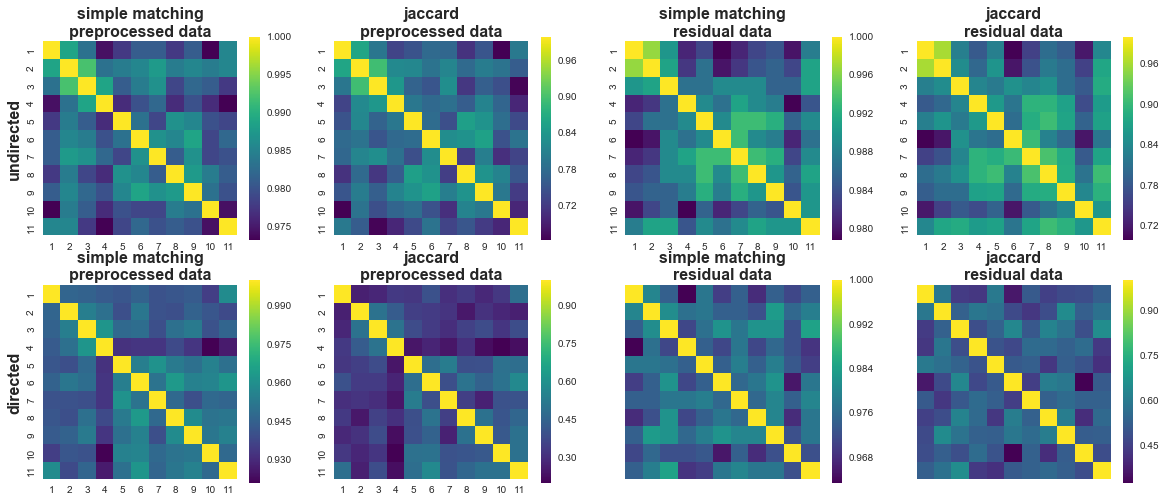

In [55]:
fig, axs = overview_plot()

In [56]:
# fig.savefig('overview_graphcomp_runs_withlofs.png', dpi=300)

# Influence of experimental stimulation

We modelled the influence of familiarity as a kind of differential regressor. For that purpose, stimulus onsets for familiar and unfamiliar faces respectively were convolved with a canonical HRF, and the result subtracted (familiar - unfamiliar).

See also the notebook 'model_contrast_for_tetrad.ipynb' and the script 'meants_tetrad.py'

## Residual data

In [57]:
path_withc_nb = pjoin('/host', 'famfaces', 'extract_meants_nuisance_button_withcontrast', 'sub*', 'csv', 'run*')

In [58]:
dfs_withc_nb = getdfs(path_withc_nb)

In [59]:
images_withc_nb = run_images_lofs(dfs_withc_nb)

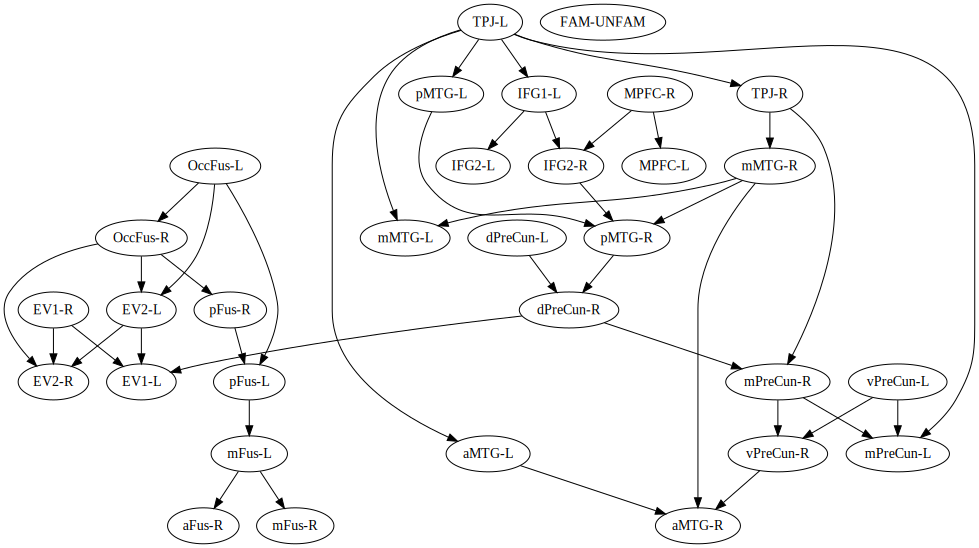

In [60]:
plot_svg(images_withc_nb)

## Preprocessed data

In [61]:
path_withc_raw = pjoin('/host', 'famfaces', 'extract_meants_withcontrast', 'sub*', 'csv', 'run*')

In [62]:
dfs_withc_raw = getdfs(path_withc_raw)

In [63]:
images_withc_raw = run_images_lofs(dfs_withc_raw)

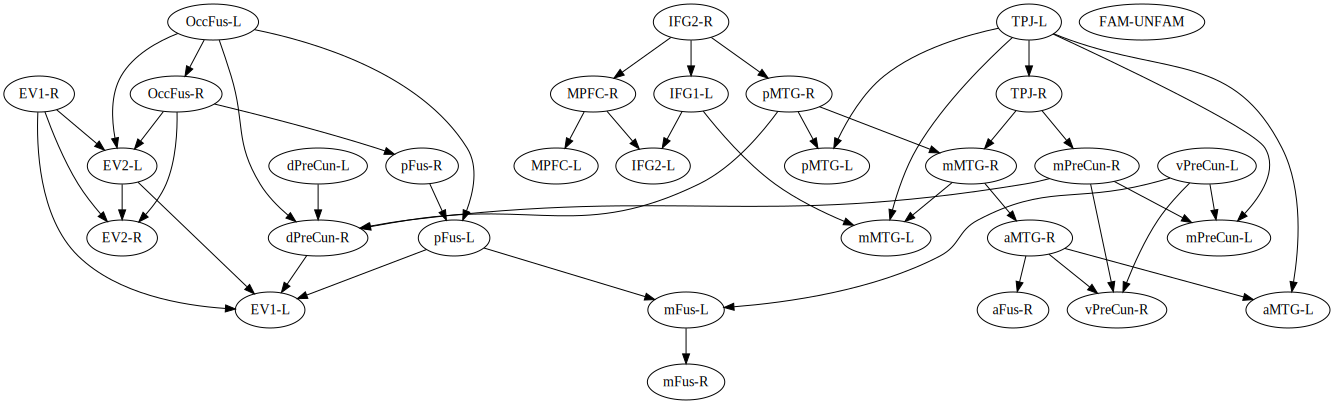

In [64]:
plot_svg(images_withc_raw)

## Conclusion stimulus modelling

The constructed differential regressor (fam-unfam) does not fit in the graph, regardless of which data is used.

# AR modelling

Explore if AR modelling changes the failure to connect the familiarity effect to the rest of the network.

## Preprocessed data

In [65]:
from statsmodels.tsa.ar_model import AR

/Users/Oliver/anaconda2/envs/famface/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [66]:
def ar_df(in_df, tr=2, lag=1):
    """
    perform AR modelling on all columns in a given data frame.
    Keep in mind that resulting data frame will be missing first row.
    """
    # don't change original data frames, make copy instead
    df = copy.deepcopy(in_df)
    
    # give df a timestamp as index
    df['time'] = range(tr,len(df)*tr+1,tr)
    df.index = pd.to_datetime(pd.to_timedelta(df['time'],unit='s'))
    df = df.drop('time', 1)
    
    # get column names
    header = list(df.columns.values)
    
    for cond in header:
        # autoregressive model
        ar_mod = AR(df[cond].astype(float), dates=df.index)

        fit = ar_mod.fit(lag)
        results = fit.predict()
        df[cond] = results # change respective column in df

    df = df.iloc[lag:] # don't include rows that are NaN due to AR
    
    return df

In [67]:
# perform AR modelling for all data frames based on preprocessed data
dfs_withc_raw_ar = [ar_df(df) for df in dfs_withc_raw]

In [68]:
images_withc_raw_ar = run_images_lofs(dfs_withc_raw_ar)

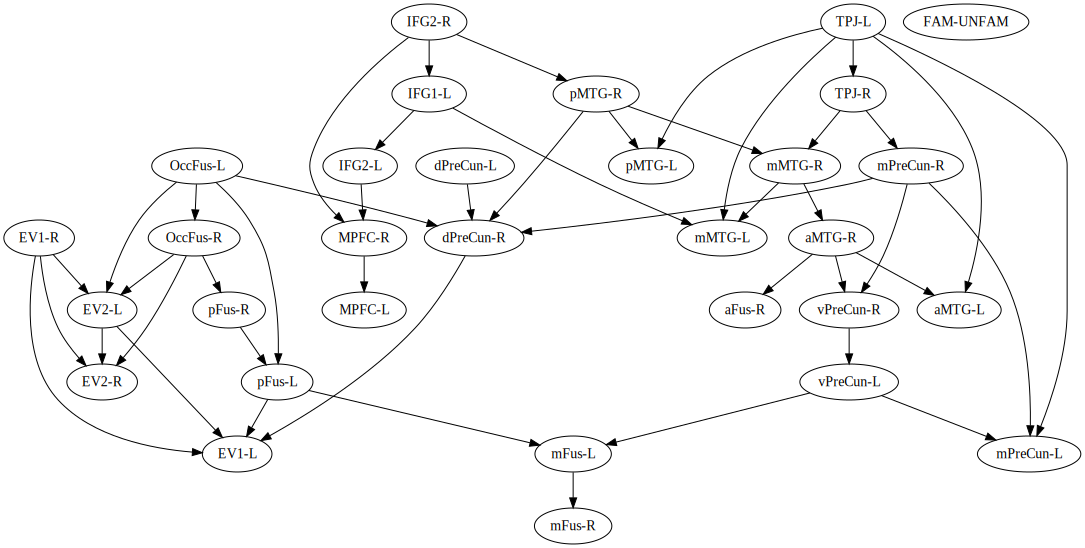

In [69]:
plot_svg(images_withc_raw_ar)

In [70]:
sb.set_style('white')

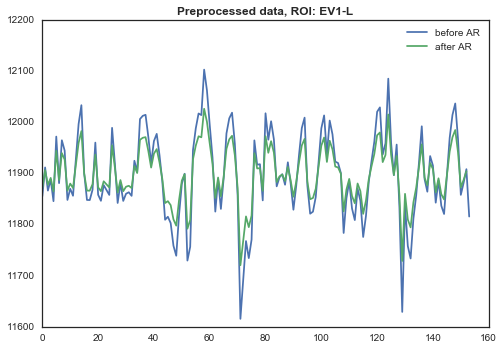

In [71]:
# time series of EV1-L before and after AR
plt.plot(dfs_withc_raw[0]['EV1-L'].values)
plt.plot(dfs_withc_raw_ar[0]['EV1-L'].values)
plt.legend(['before AR', 'after AR'])
plt.title('Preprocessed data, ROI: EV1-L', fontweight='bold')

## Residual data

In [72]:
# perform AR modelling for all data frames based on preprocessed data
dfs_withc_nb_ar = [ar_df(df) for df in dfs_withc_nb]

In [73]:
images_withc_nb_ar = run_images_lofs(dfs_withc_nb_ar)

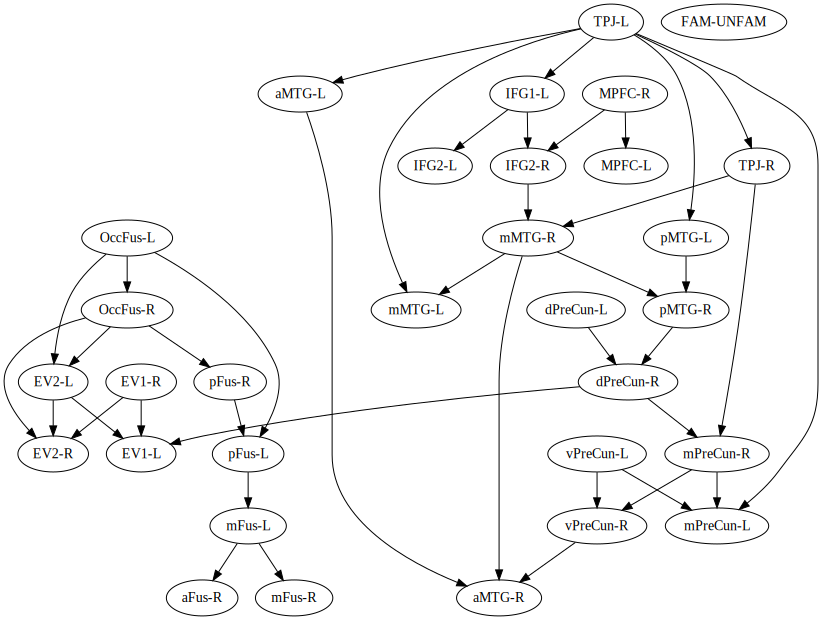

In [74]:
plot_svg(images_withc_nb_ar)

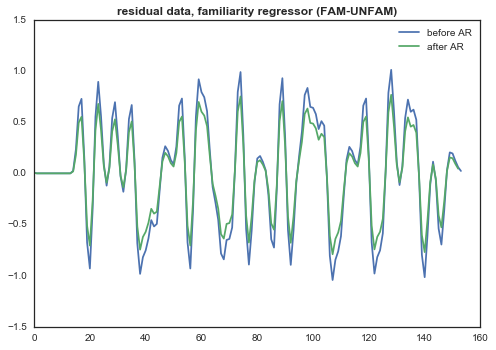

In [75]:
# example time series before and after AR in residual data
plt.plot(dfs_withc_nb[0]['FAM-UNFAM'].values)
plt.plot(dfs_withc_nb_ar[0]['FAM-UNFAM'].values)
plt.legend(['before AR', 'after AR'])
plt.title('residual data, familiarity regressor (FAM-UNFAM)', fontweight='bold')

## Conclusion AR modelling

AR modelling does not influence the graph (neither for preprocessed nor residual data).

# plot with bctp

In [76]:
"""
Get coordinates from Matteo's csv file
"""
import csv
coords_file = '/host/famfaces/rois/tetrad/roi_coord_30.csv'
with open(coords_file, 'rb') as csvfile:
    rdr = csv.reader(csvfile, delimiter=',')
    coords = [row for row in rdr]
coords = np.array([map(int, row[1:]) for row in coords[1:]])

initiate mayavi

In [77]:
!jupyter nbextension install --py mayavi --user

Installing /Users/Oliver/anaconda2/envs/famface/lib/python2.7/site-packages/mayavi/tools/static -> mayavi
Up to date: /Users/Oliver/Library/Jupyter/nbextensions/mayavi/x3d/x3dom.css
Up to date: /Users/Oliver/Library/Jupyter/nbextensions/mayavi/x3d/LICENSE.txt
Up to date: /Users/Oliver/Library/Jupyter/nbextensions/mayavi/x3d/x3dom.js
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable mayavi --user --py
    


In [78]:
# display mayavi in jupyter notebook
mlab.init_notebook()

Notebook initialized with x3d backend.


In [79]:
# create mayavi scene with bctp
bctplot_n_undir = bct.visualization.adjacency_plot_und(am_und_n, coords)

In [80]:
# call the scene
bctplot_n_undir

In [81]:
# save mayavi scene as file
mlab.savefig('testfile.png', figure=bctplot_n_undir, magnification=3)

# Which edges change?

Work in progress

## residual data

In [82]:
## reshape our list of adjacency matrices, so we can make a heatmap
## with 11 columns (for each run) and 900 rows (for each possible edge)

# np.shape(am_list_nb)
# am_list_nb_reshape = np.array(am_list_nb).reshape(900,11)
# np.shape(am_list_nb_reshape)

In [83]:
## plot heatmap

# fig, ax = plt.subplots(figsize=(18,30))
# hm = sb.heatmap(am_list_nb_reshape, cbar=False, xticklabels=False)